## This is a data analysis and training model exercise 

The kaggle dataset is this: https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [318]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torcheval.metrics import R2Score, MeanSquaredError

In [319]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Open csv file

In [320]:
df = pd.read_csv("data/california_housing_prices.csv")
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


### Checking for missing and null data

In [321]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [322]:
# Fill na values
df["total_bedrooms"] = df["total_bedrooms"].fillna(df["total_bedrooms"].interpolate()) #df.fillna(df["total_bedrooms"].interpolate(), inplace=True)
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [323]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


### Dropping ocean_proximity

Since i'm going to work with numeric data for now I'm going to drop ocean_proximity column. Later on I'll make another prediction with this column.

In [324]:
df.drop("ocean_proximity", axis=1, inplace=True)

In [325]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.717636,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,420.424655,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,646.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Basic data analysis

<Axes: xlabel='longitude', ylabel='latitude'>

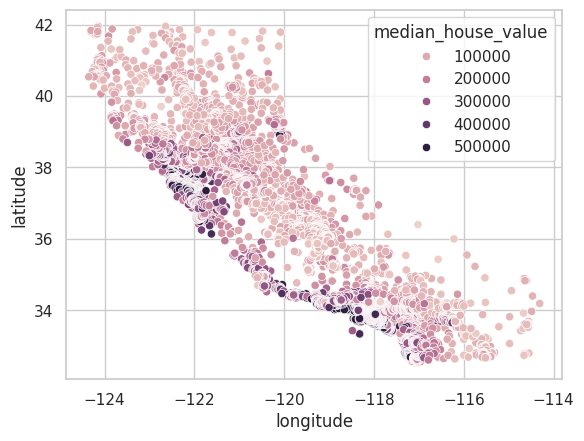

In [326]:
sns.scatterplot(data=df, x="longitude", y="latitude", hue="median_house_value")

### Normalization of data

First of all we notice that there are numbers in different scales, so we first have to normalize de dataset, otherwise the loss function won't work properly.

In [327]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df.iloc[:, :-1])  # Normalizamos X
y_scaled = scaler_y.fit_transform(df.iloc[:, -1].values.reshape(-1, 1))  # Normalizamos y

df_scaled = np.hstack((X_scaled, y_scaled))  # Juntamos X e Y normalizados
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

## Spliting training and test data

In [328]:
# Separar en train y test
separator = int(df_scaled.shape[0] * 0.8)
X_train = torch.tensor(df_scaled.iloc[:separator, 0:-1].values, dtype=torch.float32)
y_train = torch.tensor(df_scaled.iloc[:separator, -1].values, dtype=torch.float32).unsqueeze(dim=1)
X_test = torch.tensor(df_scaled.iloc[separator:, 0:-1].values, dtype=torch.float32)
y_test = torch.tensor(df_scaled.iloc[separator:, -1].values, dtype=torch.float32).unsqueeze(dim=1)


In [329]:
X_train.shape

torch.Size([16512, 8])

### Defining the model

More information about the model can be found here: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

In [330]:
class HousePriceModel(nn.Module):
	def __init__(self):
		super().__init__()
		self.model = nn.Sequential(
			nn.Linear(X_train.shape[1], 64),
			nn.Sigmoid(),
			nn.Linear(64, 32),
			nn.Sigmoid(),
			nn.Linear(32, 1)
		)

	def forward(self, x):
		return self.model(x)

#model = nn.Linear(X_train.shape[1], 1)
model = HousePriceModel()

model.state_dict()

OrderedDict([('model.0.weight',
              tensor([[ 0.2770, -0.2367, -0.3304,  0.0593, -0.1146,  0.1131, -0.0647,  0.2579],
                      [-0.1042, -0.2325,  0.2953,  0.2684,  0.1269, -0.1618,  0.0535, -0.1342],
                      [-0.3241,  0.2539,  0.2178,  0.2621,  0.1015, -0.2355, -0.2662,  0.2967],
                      [-0.0758, -0.0458, -0.1776,  0.2687, -0.2508,  0.0504,  0.0976,  0.2324],
                      [ 0.2698,  0.1532, -0.1096,  0.1297,  0.2298,  0.2418,  0.2564,  0.2731],
                      [ 0.2427,  0.1813, -0.2767, -0.0125,  0.2325, -0.2216,  0.3486,  0.0672],
                      [ 0.1936,  0.1817, -0.1347, -0.0290, -0.1199,  0.1024,  0.0383, -0.0529],
                      [-0.1193, -0.3449,  0.2801, -0.1721, -0.0985,  0.2320,  0.1428,  0.1722],
                      [-0.1009,  0.1430,  0.0479,  0.1031,  0.3043, -0.0013,  0.2838, -0.2141],
                      [-0.2467,  0.0170, -0.0465, -0.1832,  0.1673,  0.2913,  0.1527,  0.1345],
        

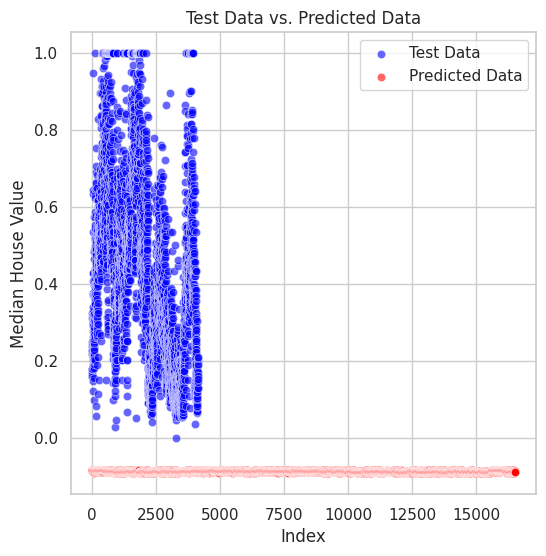

In [331]:
with torch.inference_mode():
	y_preds = model(X_train)

sns.set_theme(style="whitegrid", palette="rocket")
plt.figure(figsize=(6, 6))
ax = sns.scatterplot(x=range(len(y_test.squeeze())), y=y_test.squeeze(), label="Test Data", color="blue", alpha=0.6)
sns.scatterplot(x=range(len(y_preds.squeeze())), y=y_preds.squeeze(), label="Predicted Data", color="red", alpha=0.6, ax=ax)

ax.set_xlabel("Index")
ax.set_ylabel("Median House Value")
ax.set_title("Test Data vs. Predicted Data")
ax.legend()

plt.show()

### Training the model

In [332]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [333]:
epochs = 1000

epochs_count = []
train_loss_values = []
test_loss_values = []

# Train the model
for epoch in range(epochs):
	model.train()
	
	# 1. Forward pass
	y_pred = model(X_train)
	
	# 2. Calculate the loss
	loss = loss_fn(y_pred, y_train)

	# 3. Zero the optimizer gradients
	optimizer.zero_grad()

	# 4. Backward pass
	loss.backward()

	# 5. Optimizer step
	optimizer.step()

	model.eval()
	with torch.inference_mode():
		# 1. Do the forward pass
		y_test_pred = model(X_test)

		# 2. Calculate the loss
		test_loss = loss_fn(y_test_pred, y_test)

	if epoch % 10 == 0:
		epochs_count.append(epoch)
		train_loss_values.append(loss)
		test_loss_values.append(test_loss)
		print(f"Epochs: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epochs: 0 | Train loss: 0.47326281666755676 | Test loss: 0.48345720767974854
Epochs: 10 | Train loss: 0.1776304692029953 | Test loss: 0.2092677503824234
Epochs: 20 | Train loss: 0.20047758519649506 | Test loss: 0.2005496472120285
Epochs: 30 | Train loss: 0.1756187379360199 | Test loss: 0.2072826474905014
Epochs: 40 | Train loss: 0.1783648133277893 | Test loss: 0.2189304679632187
Epochs: 50 | Train loss: 0.17502474784851074 | Test loss: 0.2052413523197174
Epochs: 60 | Train loss: 0.1748310923576355 | Test loss: 0.20669260621070862
Epochs: 70 | Train loss: 0.1746370643377304 | Test loss: 0.21045748889446259
Epochs: 80 | Train loss: 0.17434021830558777 | Test loss: 0.20760492980480194
Epochs: 90 | Train loss: 0.17419254779815674 | Test loss: 0.20766206085681915
Epochs: 100 | Train loss: 0.1740296334028244 | Test loss: 0.2082824409008026
Epochs: 110 | Train loss: 0.1738518327474594 | Test loss: 0.20747986435890198
Epochs: 120 | Train loss: 0.17366920411586761 | Test loss: 0.207563310861587

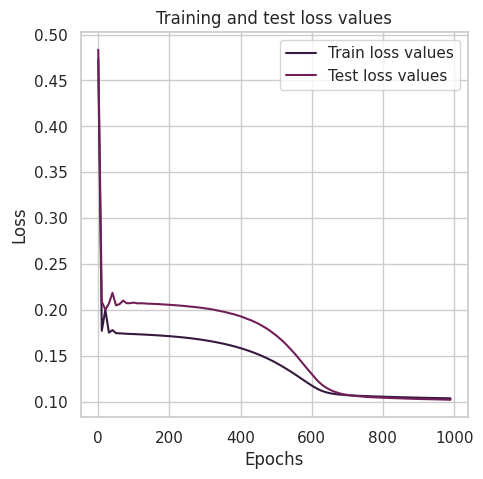

In [334]:
plt.figure(figsize=(5,5))
plt.plot(epochs_count, np.array(torch.tensor(train_loss_values).numpy()), label="Train loss values")
plt.plot(epochs_count, test_loss_values, label="Test loss values")
plt.title("Training and test loss values")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Make predictions

In [335]:
with torch.inference_mode():
	y_preds_new = model(X_test)  # Predicción en la escala normalizada
	y_preds_original_scale = scaler_y.inverse_transform(y_preds_new.numpy())  # Desnormalizamos

# Para comparar:
y_test_original_scale = scaler_y.inverse_transform(y_test.numpy())


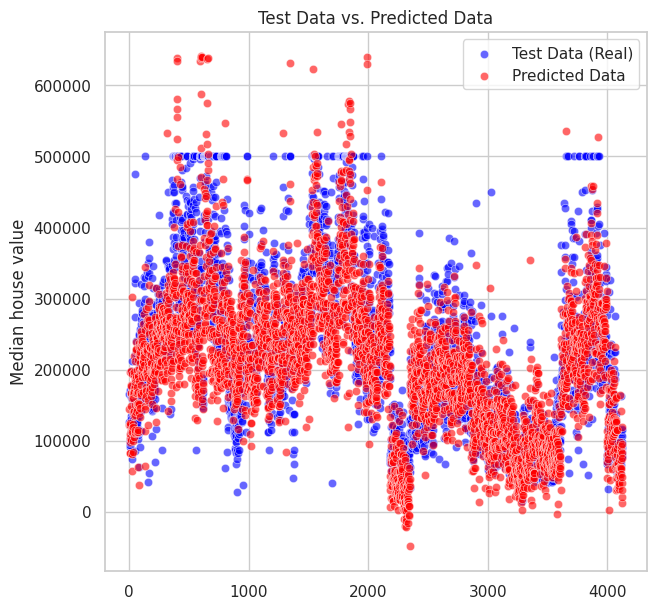

In [336]:
# Desnormalizar los valores antes de graficar
y_test_original_scale = scaler_y.inverse_transform(y_test.numpy())  # y_test en escala real
y_preds_original_scale = scaler_y.inverse_transform(y_preds_new.numpy())  # Predicciones en escala real

plt.figure(figsize=(7,7))

# Graficar los valores reales (azul)
sns.scatterplot(x=range(len(y_test_original_scale.squeeze())), 
				y=y_test_original_scale.squeeze(), 
				label="Test Data (Real)", 
				color="blue", 
				alpha=0.6)

# Graficar las predicciones (rojo)
sns.scatterplot(x=range(len(y_preds_original_scale.squeeze())), 
				y=y_preds_original_scale.squeeze(), 
				label="Predicted Data", 
				color="red", 
				alpha=0.6)

# Etiquetas y título
plt.ylabel("Median house value")
plt.title("Test Data vs. Predicted Data")
plt.legend()

plt.show()


### Metrics

In [337]:
y_test_tensor = torch.tensor(y_test_original_scale, dtype=torch.float32)
y_preds_tensor = torch.tensor(y_preds_original_scale, dtype=torch.float32)

# Crear la métrica MSE
mse = MeanSquaredError()

# Calcular MSE
mse.update(y_preds_tensor, y_test_tensor)

r2 = R2Score()
r2.update(torch.tensor(y_test_original_scale), torch.tensor(y_preds_original_scale))

mse.compute(), r2.compute()

(tensor(4.7938e+09), tensor(0.5163))